In [278]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import xgboost as xgb
from sklearn.metrics import plot_confusion_matrix

In [279]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q,globals())

In [280]:
df = pd.read_csv('../../data/data/H161.csv', parse_dates=['utc_time'])
df.columns = ['time','batch','phase', 'heat_time', 'weight', 'head_temp', 'head_pressure', 'vac_temp']

C:\Users\lbushman\AppData\Local\Temp\ipykernel_12588\1626634897.py:1: DtypeWarning: Columns (1,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../data/data/H161.csv', parse_dates=['utc_time'])


In [281]:
df = df[df['phase'].str.contains ('DRYING|DISCHRG') == True]
# df = df[df['phase'].str.contains ('DRYING') == True]


In [282]:
df["time"] = df["time"].dt.tz_localize(None)
df['date'] = df['time'].dt.date
df['day'] = df['time'].dt.dayofweek


In [283]:
df.replace({'??????': None}, inplace=True)
df.replace({'????????': None}, inplace=True)
df.dropna(inplace=True)

In [284]:
df['head_temp'] = df.head_temp.astype(float)
df['weight'] = df.weight.astype(float)
df['head_pressure'] = df.head_pressure.astype(float)
df['heat_time'] = df.heat_time.astype(float)
df['vac_temp'] = df.vac_temp.astype(float)
df['batch'] = df.batch.astype(float)
df['phase'] = df.phase.astype('category')

In [285]:
n = 30  # number of points to be checked before and after

# Find local peaks
df['max_temp'] = 0
df['max_temp'] = df.iloc[argrelextrema(df.head_temp.values, np.greater_equal, order=n)]['head_temp']

In [286]:
df['ready'] = 0
delta_t = 2

for i in range (1, len(df['ready']-1)):
    if df.max_temp.values[i] > 0:
        local_max = df.max_temp.values[i]
        current = df.batch.values[i]
        while df['batch'].values[i] == current:
            if local_max - df.head_temp.values[i] > delta_t:
                i += 1
                df.ready.values[i] = 1
            else:
                i += 1
                df.ready.values[i] = 2
            
                
df = df.drop(['max_temp'], axis=1)
df = df[df['phase'].str.contains ('DRYING') == True]

In [287]:
df['head_pressure_20'] = df['head_pressure'].shift(-20)
df['head_temp_20'] = df['head_temp'].shift(-20)
df['weight_20'] = df['weight'].shift(-20)
df['heat_time_20'] = df['heat_time'].shift(-20)
df['vac_temp_20'] = df['vac_temp'].shift(-20)

df['head_pressure_30'] = df['head_pressure'].shift(-30)
df['head_temp_30'] = df['head_temp'].shift(-30)
df['weight_30'] = df['weight'].shift(-30)
df['heat_time_30'] = df['heat_time'].shift(-30)
df['vac_temp_30'] = df['vac_temp'].shift(-30)

df['head_pressure_40'] = df['head_pressure'].shift(-40)
df['head_temp_40'] = df['head_temp'].shift(-40)
df['weight_40'] = df['weight'].shift(-40)
df['heat_time_40'] = df['heat_time'].shift(-40)
df['vac_temp_40'] = df['vac_temp'].shift(-40)
df.dropna(inplace=True)
df.head()


,time,batch,phase,heat_time,weight,head_temp,head_pressure,vac_temp,date,day,...,head_pressure_30,head_temp_30,weight_30,heat_time_30,vac_temp_30,head_pressure_40,head_temp_40,weight_40,heat_time_40,vac_temp_40
28,2020-04-17 11:49:11,22096.0,DRYING,25.4,3956.1,57.5,186.7,31.27,2020-04-17,4,...,222.7,57.6,3901.6,55.4,32.95,264.7,57.8,3884.9,65.4,32.98
29,2020-04-17 11:50:11,22096.0,DRYING,26.4,3954.5,57.5,186.2,31.34,2020-04-17,4,...,226.9,57.6,3899.9,56.4,32.95,268.9,57.8,3883.3,66.4,32.98
30,2020-04-17 11:51:11,22096.0,DRYING,27.4,3952.9,57.5,185.7,31.42,2020-04-17,4,...,231.1,57.7,3898.2,57.4,32.95,273.0,57.9,3881.6,67.4,32.99
31,2020-04-17 11:52:11,22096.0,DRYING,28.4,3951.4,57.5,185.2,31.50,2020-04-17,4,...,235.3,57.7,3896.6,58.4,32.96,277.2,57.9,3880.0,68.4,32.99
32,2020-04-17 11:53:11,22096.0,DRYING,29.4,3949.8,57.5,184.7,31.58,2020-04-17,4,...,239.5,57.7,3894.9,59.4,32.96,281.4,57.9,3878.3,69.4,32.99


In [288]:
# def load_query(path):
#     with open(path) as file:
#         return file.read()

In [289]:
# query = load_query('queries/daily_cycles.sql')
# daily_cycles = pysqldf(query)

In [290]:
# daily_cycles.sample(4)

In [291]:
# daily_cycles.describe()

In [292]:
import logging
logging.getLogger().setLevel(logging.CRITICAL)

In [293]:
# plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi': 300})
# fig, ax = plt.subplots()
# sns.lineplot(data=daily_cycles.tail(50), x='DATE', y='num_cycles')
# plt.grid(linestyle='-', linewidth=0.3)
# ax.tick_params(axis='x', rotation=90)

In [294]:
# query = load_query('queries/weekly_cycles.sql')
# weekly_cycles = pysqldf(query)

In [295]:
# weekly_cycles.tail()

In [296]:
# plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi': 300})
# fig, ax = plt.subplots()
# sns.lineplot(data=weekly_cycles.tail(50), x='week', y='num_cycles')
# plt.grid(linestyle='-', linewidth=0.3)
# ax.tick_params(axis='x', rotation=90)

In [297]:
df = df[df['ready'] < 2]

In [325]:



features = [
            # 'heat_time', 'weight', 'head_temp', 'head_pressure', 'vac_temp',
            # 'heat_time_20', 'weight_20', 'head_temp_20', 'head_pressure_20', 'vac_temp_20',
            'heat_time_30', 'weight_30', 'head_temp_30', 'head_pressure_30', 'vac_temp_30',
            'heat_time_40', 'weight_40', 'head_temp_40', 'head_pressure_40', 'vac_temp_40'
            ]
label = ['ready']
train_df = df.head(int(df.shape[0]*.75))
test_df = df.tail(int(df.shape[0]*0.25))


X_train, y_train = train_df[features], train_df[label]
X_test, y_test = test_df[features], test_df[label]


In [334]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            # gamma=0.25,
                            max_depth=8,
                            seed=42)

In [335]:
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_train, y_train),(X_test, y_test)])

C:\Users\lbushman\.virtualenvs\drayers-ZSJxV8Z-\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\lbushman\.virtualenvs\drayers-ZSJxV8Z-\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\lbushman\.virtualenvs\drayers-ZSJxV8Z-\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

[0]	validation_0-aucpr:0.98668	validation_1-aucpr:0.96084
[1]	validation_0-aucpr:0.98925	validation_1-aucpr:0.96856
[2]	validation_0-aucpr:0.99089	validation_1-aucpr:0.97338
[3]	validation_0-aucpr:0.99155	validation_1-aucpr:0.97469
[4]	validation_0-aucpr:0.99233	validation_1-aucpr:0.97415
[5]	validation_0-aucpr:0.99283	validation_1-aucpr:0.97486
[6]	validation_0-aucpr:0.99335	validation_1-aucpr:0.97515
[7]	validation_0-aucpr:0.99398	validation_1-aucpr:0.97539
[8]	validation_0-aucpr:0.99438	validation_1-aucpr:0.97529
[9]	validation_0-aucpr:0.99471	validation_1-aucpr:0.97561
[10]	validation_0-aucpr:0.99508	validation_1-aucpr:0.97560
[11]	validation_0-aucpr:0.99539	validation_1-aucpr:0.97580
[12]	validation_0-aucpr:0.99560	validation_1-aucpr:0.97592
[13]	validation_0-aucpr:0.99584	validation_1-aucpr:0.97689
[14]	validation_0-aucpr:0.99598	validation_1-aucpr:0.97639
[15]	validation_0-aucpr:0.99623	validation_1-aucpr:0.97598
[16]	validation_0-aucpr:0.99630	validation_1-aucpr:0.97557
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

<AxesSubplot:>

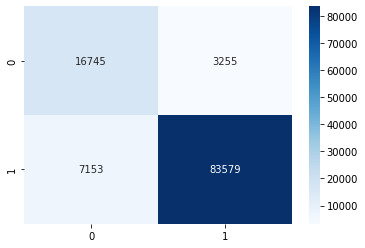

In [336]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = clf_xgb.predict_proba(X_test)[:,1]
thr=0.7
sns.heatmap(confusion_matrix(y_test,pred>thr),annot=True,fmt='', cmap='Blues')

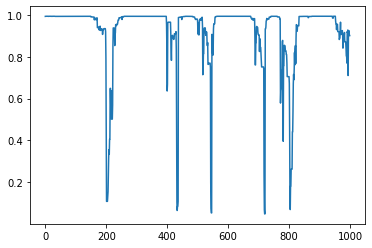

In [337]:
plt.plot(pd.Series(pred[-1000:]))

C:\Users\lbushman\.virtualenvs\drayers-ZSJxV8Z-\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\lbushman\.virtualenvs\drayers-ZSJxV8Z-\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


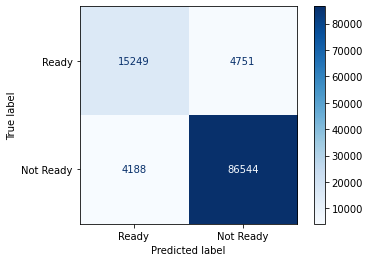

In [338]:
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      cmap='Blues',
                      display_labels=['Ready', 'Not Ready'])

In [339]:
bst = clf_xgb.get_booster()
for importance_type in ('weight','gain', 'cover', 'total_gain','total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

weight:  {'heat_time_30': 483.0, 'weight_30': 455.0, 'head_temp_30': 389.0, 'head_pressure_30': 270.0, 'vac_temp_30': 492.0, 'heat_time_40': 345.0, 'weight_40': 326.0, 'head_temp_40': 364.0, 'head_pressure_40': 241.0, 'vac_temp_40': 449.0}
gain:  {'heat_time_30': 212.7633819580078, 'weight_30': 55.19824981689453, 'head_temp_30': 238.9092254638672, 'head_pressure_30': 54.632225036621094, 'vac_temp_30': 67.7187728881836, 'heat_time_40': 111.47657012939453, 'weight_40': 34.247501373291016, 'head_temp_40': 53.64182662963867, 'head_pressure_40': 95.41001892089844, 'vac_temp_40': 44.261722564697266}
cover:  {'heat_time_30': 3123.6630859375, 'weight_30': 1229.0386962890625, 'head_temp_30': 2910.816162109375, 'head_pressure_30': 1149.8292236328125, 'vac_temp_30': 1204.690185546875, 'heat_time_40': 1573.331298828125, 'weight_40': 792.3923950195312, 'head_temp_40': 1439.430908203125, 'head_pressure_40': 981.6755981445312, 'vac_temp_40': 1135.4512939453125}
total_gain:  {'heat_time_30': 102764.71

In [350]:
 from sklearn.metrics import accuracy_score

accuracy_score(y_true=y_test, y_pred=clf_xgb.predict_proba(X_test)[:,1]>0.5, normalize=True)

C:\Users\lbushman\.virtualenvs\drayers-ZSJxV8Z-\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.9192735613914677

In [ ]:
node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}
xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)